## keras构建分类模型(加入keras相关callback)

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.0
numpy 1.14.5
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all, y_train_all), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_all[:5000], X_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(X_valid.shape, y_valid.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [6]:
# 数据归一化,标准归一化 x = (x - u) / std
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 对于训练集使用fit_transform，该函数会在归一化结束后保存训练集中的均值方差，并使用这两个参数进行验证集和测试集的归一化
# 归一化之前将数据转为浮点型，防止精度损失
# 还有该函数接收的数据类型为二维数组，所以这里先reshape
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
print(np.max(X_train_scaled), np.min(X_train_scaled))

2.0231433 -0.8105136


In [7]:
# 构建模型
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

添加callbacks：TensorBoard, EarlyStopping, ModelCheckpoint

In [9]:
# tensorboard需要指定一个log dir
log_dir = './callbacks'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
# ModelCheckpoint需要指定一个保存模型数据的文件名
output_model_file = os.path.join(log_dir, 'fashion_mnist_model.h5')
    
callbacks = [
    keras.callbacks.TensorBoard(log_dir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    # 默认监测数据为验证集上的loss(val_loss)，min_delta值表示被监测数据的最小变化量
    # patience表示等待几次监测数据没有提升，在这之后，训练将被终止
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

In [14]:
log_his = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_valid_scaled, y_valid),
                   callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.3074 - accuracy: 0.8918 - val_loss: 0.3387 - val_accuracy: 0.8798
Epoch 2/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3052 - accuracy: 0.8917 - val_loss: 0.3345 - val_accuracy: 0.8808
Epoch 3/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3024 - accuracy: 0.8931 - val_loss: 0.3342 - val_accuracy: 0.8784
Epoch 4/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3001 - accuracy: 0.8935 - val_loss: 0.3389 - val_accuracy: 0.8804
Epoch 5/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.2978 - accuracy: 0.8955 - val_loss: 0.3351 - val_accuracy: 0.8796
Epoch 6/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.2954 - accuracy: 0.8955 - val_loss: 0.3284 - val_accuracy: 0.8792
Epoch 7/10
55000/55000 [==============================] -

## 开启tensorboard服务 
在终端中切换到callbacks目录，输入命令`tensorboard --logdir=dir名称`，服务默认端口号6006   

![demo](./img/boarddemo.png)

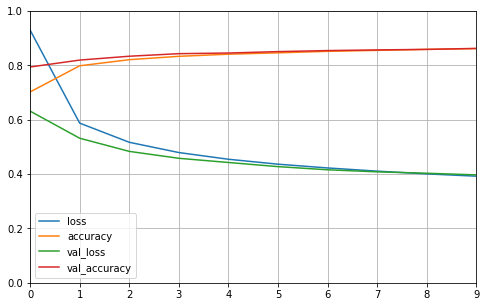

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(log_his)

In [12]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 42us/sample - loss: 0.4312 - accuracy: 0.8457


[0.4311638023614883, 0.8457]